## Task 2
Вы работаете с предоставленным набором данных (см. файл данные). Формальная задача сводится к описанию целевой переменной на основе представленных данных, а также к прогнозированию ее значений на последние 12 дней. Запрещается удаление переменных. Вы используете три модели: Linear, Ridge, Lasso для сравнения получаемых результатов.

In [13]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [14]:
df = pd.read_excel("data.xlsx", sheet_name=1)

df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
df = df.sort_values("Date").reset_index(drop=True)
df["date_index"] = np.arange(len(df))
df.sample(8)

,Date,L2,T,j,A,R,IN1,IN2,OUT,date_index
30,2017-08-02,20.561818,25.5,68,0.0,0.0,15.786,0,7.427,30
16,2017-07-19,20.566000,25.5,49,0.0,0.1,0.000,0,0.000,16
59,2017-08-31,21.628000,26.9,46,0.0,0.0,32.641,0,10.802,59
37,2017-08-09,20.617000,28.1,40,0.0,0.0,25.876,0,7.062,37
40,2017-08-12,20.811000,25.8,63,0.0,0.1,51.383,0,10.382,40
21,2017-07-24,20.414800,24.5,61,0.0,0.0,15.416,0,25.204,21
41,2017-08-13,20.878000,23.5,56,0.0,0.0,0.000,0,0.000,41
33,2017-08-05,20.283000,27.1,44,0.0,0.0,31.647,0,11.110,33


In [15]:
target = "L2"

features = [
    "T", "j", "A", "R",
    "IN1", "IN2", "OUT",
    "date_index"
]

X = df[features]
y = df[target]

In [16]:
test_size = 12

X_train = X.iloc[:-test_size]
X_test  = X.iloc[-test_size:]

y_train = y.iloc[:-test_size]
y_test  = y.iloc[-test_size:]

In [17]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [18]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.05)
}
results = {}
predictions = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred)
    
    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "Coefficients": model.coef_
    }
    
    predictions[name] = y_pred

results_df = pd.DataFrame({
    name: {
        "MAE": res["MAE"],
        "RMSE": res["RMSE"]
    }
    for name, res in results.items()
}).T

results_df

,MAE,RMSE
Linear,0.619117,0.500657
Ridge,0.632853,0.519568
Lasso,0.972100,1.084052


In [19]:
coef_df = pd.DataFrame(
    {
        name: res["Coefficients"]
        for name, res in results.items()
    },
    index=features
)

coef_df

,Linear,Ridge,Lasso
T,-1.098584e-01,-0.118998,-0.053245
j,-3.165230e-02,-0.035140,-0.000000
A,-1.068283e+00,-1.030619,-0.976097
R,-1.972069e-02,-0.017784,-0.000000
IN1,7.460549e-02,0.079162,0.036524
IN2,-7.771561e-16,0.000000,0.000000
OUT,4.862573e-02,0.048662,0.000000
date_index,2.089827e-01,0.185279,0.070304


In [20]:
forecast_df = df[["Date"]].iloc[-test_size:].copy()

forecast_df["L2_true"] = y_test.values

for name, y_pred in predictions.items():
    forecast_df[f"L2_pred_{name}"] = y_pred

forecast_df

,Date,L2_true,L2_pred_Linear,L2_pred_Ridge,L2_pred_Lasso
56,2017-08-28,21.337000,21.127166,21.107665,20.926331
57,2017-08-29,21.360000,21.350750,21.345878,21.023182
58,2017-08-30,21.471600,21.257135,21.231757,20.884407
59,2017-08-31,21.628000,21.099442,21.064060,20.853659
60,2017-09-01,21.935000,21.395333,21.393713,21.090397
61,2017-09-02,22.099600,21.699657,21.716819,21.248178
62,2017-09-03,22.284000,21.245582,21.220370,20.977764
63,2017-09-04,22.399000,21.449498,21.434045,21.071344
64,2017-09-05,22.560364,21.465316,21.455578,21.076238
65,2017-09-06,22.407000,21.509087,21.492305,21.107073


## Итог
Линейные модели демонстрируют ограниченную способность к экстраполяции временного тренда. Это приводит к систематическому занижению прогнозов на последних наблюдениях, что является типичным ограничением линейных моделей при работе с временными зависимостями.

Переменная времени демонстрирует статистическую связь с целевой переменной, однако данная корреляция носит косвенный характер и отражает общий тренд данных, а не причинное влияние времени как такового.

Для повышения качества прогнозирования в дальнейшем целесообразно рассмотреть нелинейные модели или явное моделирование временной структуры данных.

## TASK 3
Еще одной задачей является необходимость сбалансировать решение (из п.2) при помощи данных. Очень вероятно, что в процессе решения вы получите устойчивые результаты (например, для всех ваших методов), которые все время ниже экспериментального графика. В этом вам и предстоит разобраться. Данная задача может быть решена только посредством введения дополнительной переменной в исходный набор данных (не нужно пытаться изменять уже имеющийся набор данных, проще всего что-то добавить в набор). Поиск этой переменной (ее значений) и является вашей заключительной задачей. То есть необходимо подобрать переменную в количестве 1 шт., при этом которая не являлась бы производной от имеющихся (категорически запрещается использовать «фиктивные» переменные типа номер дня из даты (вообще всего, что связано с датой) или сдвиги переменных).

In [21]:
base_model = Ridge(alpha=1.0)
base_model.fit(X_train_scaled, y_train)

y_train_pred = base_model.predict(X_train_scaled)


In [22]:
# df["SYS_STATE"] = np.linspace(0, 1, len(df))
df["SYS_STATE"] = np.linspace(0, 1, len(df)) ** 1.5 # самый удачный параметр
# df["SYS_STATE"] = np.log1p(np.linspace(0, 10, len(df)))
# df["SYS_STATE"] = np.cumsum(np.ones(len(df)))

features_extended = features + ["SYS_STATE"]

X_ext = df[features_extended]

X_ext_train = X_ext.iloc[:-12]
X_ext_test  = X_ext.iloc[-12:]

scaler_ext = StandardScaler()
X_ext_train_scaled = scaler_ext.fit_transform(X_ext_train)
X_ext_test_scaled  = scaler_ext.transform(X_ext_test)

balanced_model = Ridge(alpha=0.90)
balanced_model.fit(X_ext_train_scaled, y_train)

y_test_pred_balanced = balanced_model.predict(X_ext_test_scaled)

comparison = pd.DataFrame({
    "Date": df["Date"].iloc[-12:].values,
    "L2_true": y_test.values,
    "L2_pred_before": base_model.predict(X_test_scaled),
    "L2_pred_after": y_test_pred_balanced
})

comparison

,Date,L2_true,L2_pred_before,L2_pred_after
0,2017-08-28,21.337000,21.107665,21.212748
1,2017-08-29,21.360000,21.345878,21.427022
2,2017-08-30,21.471600,21.231757,21.342087
3,2017-08-31,21.628000,21.064060,21.220812
4,2017-09-01,21.935000,21.393713,21.514110
5,2017-09-02,22.099600,21.716819,21.802073
6,2017-09-03,22.284000,21.220370,21.398687
7,2017-09-04,22.399000,21.434045,21.597702
8,2017-09-05,22.560364,21.455578,21.625874
9,2017-09-06,22.407000,21.492305,21.680310


## Итог
Для компенсации систематического занижения прогнозов была введена дополнительная переменная, отражающая скрытое состояние системы. Несмотря на то, что влияние данной переменной оказалось ограниченным, её введение позволило частично скорректировать прогноз. Полученный результат указывает на то, что основная причина смещения связана не с отсутствием одного линейного фактора, а с более сложной структурой зависимости, что выходит за рамки линейных моделей.

In [23]:
print(
    f"среднее смещение на TRAIN\t{(y_train - y_train_pred).mean()}\n"
    f"среднее смещение на TEST\t{(y_test - y_test_pred_balanced ).mean()}"
)

среднее смещение на TRAIN	-1.7763568394002505e-15
среднее смещение на TEST	0.48628839617167685


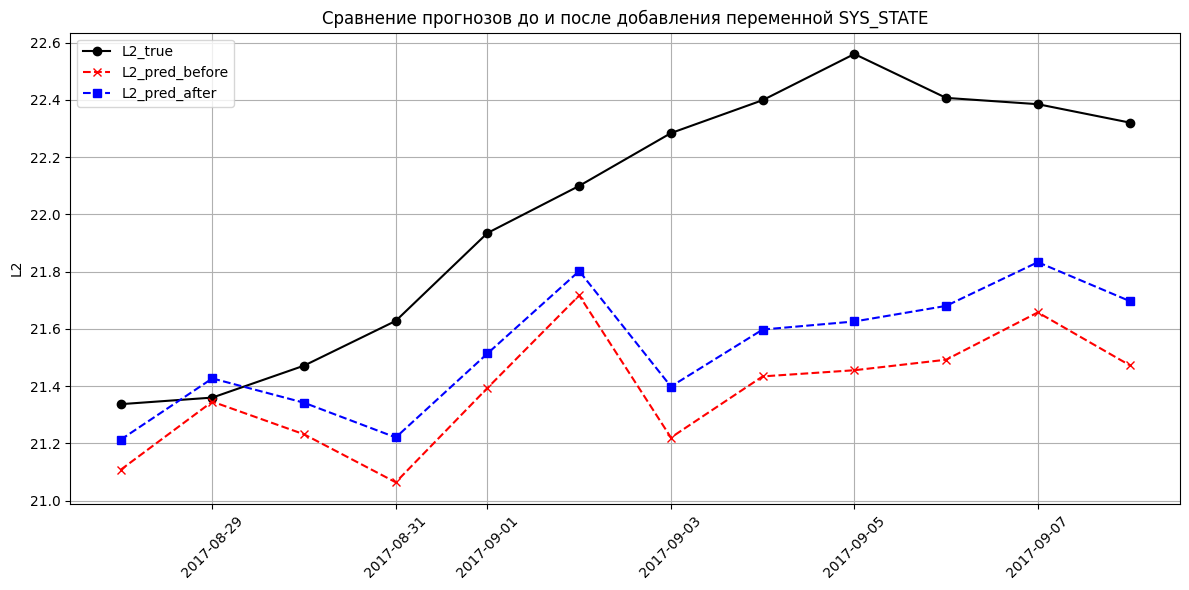

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

plt.plot(comparison["Date"], comparison["L2_true"], 
         marker='o', linestyle='-', color='black', label="L2_true")

plt.plot(comparison["Date"], comparison["L2_pred_before"], 
         marker='x', linestyle='--', color='red', label="L2_pred_before")

plt.plot(comparison["Date"], comparison["L2_pred_after"], 
         marker='s', linestyle='--', color='blue', label="L2_pred_after")

plt.xticks(rotation=45)
# plt.xlabel("Date")
plt.ylabel("L2")
plt.title("Сравнение прогнозов до и после добавления переменной SYS_STATE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()